# Image Classification with Hugging Face Transformers (ViT) and Tensorflow

## Introduction



- We are going to use the [EuroSAT](https://paperswithcode.com/dataset/eurosat) dataset for land use and land cover classification. 
- The dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes within total 27,000 labeled and geo-referenced images.


## Installation

In [ ]:
#!pip install "tensorflow==2.6.0"
!pip install transformers datasets tensorboard==2.9 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 31.1 MB/s 
     |████████████████████████████████| 451 kB 70.6 MB/s 
     |████████████████████████████████| 5.8 MB 62.7 MB/s 
     |████████████████████████████████| 7.6 MB 64.1 MB/s 
     |████████████████████████████████| 182 kB 78.9 MB/s 
     |████████████████████████████████| 212 kB 64.7 MB/s 
     |████████████████████████████████| 132 kB 75.5 MB/s 
     |████████████████████████████████| 127 kB 77.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1


In [ ]:
!sudo apt-get install git-lfs

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


## Setup & Configuration


In [ ]:
model_id = "google/vit-base-patch16-224-in21k"

## Dataset & Pre-processing


In [ ]:
from datasets import load_dataset

eurosat_ds = load_dataset('imagefolder', data_files='https://madm.dfki.de/files/sentinel/EuroSAT.zip')
eurosat_ds

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

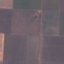

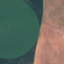

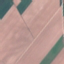

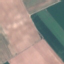

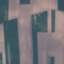

In [ ]:
for i in range(5):
  display(eurosat_ds['train'][i]['image'])

In [ ]:
img_class_labels = eurosat_ds['train'].features["label"].names
img_class_labels

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
from datasets import concatenate_datasets

samples_per_label = 50
sample = []
num_labels = len(img_class_labels)
seed = 1

for i in range(num_labels):
    sample.append(eurosat_ds["train"].filter(lambda x: x["label"] == i).shuffle(seed=seed).select(range(samples_per_label)))

sample_eurosat = concatenate_datasets(sample)
sample_eurosat

Dataset({
    features: ['image', 'label'],
    num_rows: 500
})

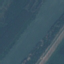

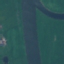

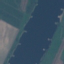

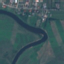

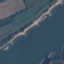

In [ ]:
for i in range(5):
  display(sample_eurosat[400+i]['image'])

## Pre-processing


In [ ]:
from transformers import ViTFeatureExtractor
from tensorflow import keras 
from tensorflow.keras import layers


feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(feature_extractor.size, feature_extractor.size),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# use keras image data augementation processing
def augmentation(examples):
    # print(examples["img"])
    examples["pixel_values"] = [data_augmentation(image) for image in examples["image"]]
    return examples


# basic processing (only resizing)
def pre_process(examples):
    examples.update(feature_extractor(examples['image'], ))
    return examples

sample_eurosat = sample_eurosat.rename_column("label", "labels")
sample_eurosat


Dataset({
    features: ['image', 'labels'],
    num_rows: 500
})

In [ ]:
processed_dataset = sample_eurosat.map(pre_process, batched=True)
processed_dataset

# # augmenting dataset takes a lot of time
# processed_dataset = eurosat_ds.map(augmentation, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['image', 'labels', 'pixel_values'],
    num_rows: 500
})

In [ ]:
#processed_dataset = eurosat_ds.with_transform(augmentation)
#processed_dataset

In [ ]:
# test size will be 15% of train dataset
test_size=.15

processed_dataset = processed_dataset.shuffle().train_test_split(test_size=test_size)
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 425
    })
    test: Dataset({
        features: ['image', 'labels', 'pixel_values'],
        num_rows: 75
    })
})

## Fine-tuning the model using `Keras`




- Need to convert Hugging Face `datasets` Dataset into a `tf.data.Dataset`. 
- Use the `.to_tf_dataset` method and a `data collator`

## Hyperparameter

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 2 # 8
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate = 0.01
num_warmup_steps = 0
output_dir = model_id.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-euroSat'
fp16=True

# Train in mixed-precision float16
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")


## Converting the dataset to a `tf.data.Dataset`

In [ ]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = processed_dataset["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = processed_dataset["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

## Download the pretrained transformer model and fine-tune it. 

In [ ]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(img_class_labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics 
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Callbacks

As mentioned in the beginning we want to use the [Hugging Face Hub](https://huggingface.co/models) for model versioning and monitoring. Therefore we want to push our model weights, during training and after training to the Hub to version it.
Additionally, we want to track the performance during training therefore we will push the `Tensorboard` logs along with the weights to the Hub to use the "Training Metrics" Feature to monitor our training in real-time. 



In [ ]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks = []

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
if hub_token:
  callbacks.append(PushToHubCallback(output_dir=output_dir,
                                     hub_model_id=hub_model_id,
                                     hub_token=hub_token))



## Training


In [ ]:
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/2
14/14 [==============================] - 94s 5s/step - loss: 2.2148 - accuracy: 0.3459 - top-3-accuracy: 0.6400 - val_loss: 2.1026 - val_accuracy: 0.6533 - val_top-3-accuracy: 0.8933
Epoch 2/2
14/14 [==============================] - 59s 4s/step - loss: 2.0309 - accuracy: 0.7835 - top-3-accuracy: 0.9624 - val_loss: 2.0241 - val_accuracy: 0.7467 - val_top-3-accuracy: 0.9200


## Inference

In [ ]:
from transformers import pipeline

test_image = eurosat_ds['train'][-1]['image']

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
classifier = pipeline('image-classification', model=model, feature_extractor=feature_extractor)
classifier(test_image)

KeyError: ignored